In [1]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.Chebyschev_coefs as ch
import pylib.qucf_read as qucf_r

8765
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
cmap_matrix = 'bwr'
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)
colors_ = ["b", "r", "g", "magenta", "black"]

path_save_ = "./jupyter-notebooks/NL/results/"

In [3]:
for _ in range(30):
    plt.close()

In [4]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

sel_case_ = 10

# --- 2 fixed points: MAIN ---
if sel_case_ == 0:
    F_ = lambda x:  - x* (x**2 - 0.25) 
    t_max, x_max, x_center = 4.0, 1, 0.25 
    x_centers_ = [- x_center, x_center, 3.*x_center, - 3.*x_center]
    # Di, str_Diff = 1e-4, "D = 1\cdot 10^{-4}" 
    Di, str_Diff = 2e-4, "D = 2\cdot 10^{-4}" 

if sel_case_ == 1:
    F_ = lambda x:  - x* (x**2 - 0.25) 
    t_max, x_max, x_center = 16.0, 1, 0.25  
    x_centers_ = [-0.95 + 0.05 * ii for ii in range(40)]
    Di, str_Diff = 2.0e-4, "D = 2\cdot 10^{-4}" # dissipation for the case where the KvN with CFD scheme AND dissipation

# --- (>2) attractors ---
if sel_case_ == 2:
    # F_ = lambda x:  - x**2 * (x - 0.8) * (x + 0.3) * (x - 0.8)
    F_ = lambda x:  - x**2 * (x - 0.8)**2 * (x + 0.6)
    t_max, x_max, x_center = 16.0, 1, 0.10 
    x_centers_ = [-0.95 + 0.05 * ii for ii in range(40)]
    Di, str_Diff = 3.8e-4, "D = 4\cdot 10^{-4}" # dissipation for the case where the KvN with CFD scheme AND dissipation

# --- 1 attractor ---
if sel_case_ == 3:
    F_ = lambda x:  - (x - 0.50)
    t_max, x_max, x_center = 16.0, 1, 0.10 
    x_centers_ = [-0.95 + 0.05 * ii for ii in range(40)]
    Di, str_Diff = 9.6e-4, "D = 1\cdot 10^{-3}" # dissipation for the case where the KvN with CFD scheme AND dissipation

# --- 2 attractor ---
if sel_case_ == 4:
    F_ = lambda x:  - (x - 0.80)*(x**4 - 0.09)
    t_max, x_max, x_center = 16.0, 1, 0.10 
    x_centers_ = [-0.95 + 0.1 * ii for ii in range(20)]
    Di = 7e-4 # dissipation for the case where the KvN with CFD scheme AND dissipation

# --- 2 fixed points: SIN ---
if sel_case_ == 10:
    F_ = lambda x:  - np.sin(x)* (np.sin(x)**2 - 0.25) 
    t_max, x_max, x_center = 4.0, 1, 0.25 
    x_centers_ = [- x_center, x_center, 3.*x_center, - 3.*x_center]
    Di, str_Diff = 2e-4, "D = 2\cdot 10^{-4}" 

# ----------------------------------------

flag_sim_ = True # if False, then only plot the resulting matrices;
flag_DI_Z = False # if True, use zero boundary conditions in the case with diffusivity

if flag_sim_:
    nx, nt = 7, 13  # for simulations: use nt = 11 for t_max = 4;
else:
    # nx, nt = 3, 11  # for plotting
    nx, nt = 4, 11  # for plotting

Nx = 1<<nx
Nt = 1<<nt
x = np.linspace(-x_max, x_max, Nx)  # !!! main !!!
t = np.linspace(0,t_max,Nt)
dx = np.diff(x)[0]
dt = np.diff(t)[0]

# ------------------------------------------------------

# --- Initial conditions ---
if sel_case_ == 0:
    psi_init_ = np.zeros(Nx, dtype=float)
    delta_gauss = 0.05
    for ii in range(Nx):
        psi_init_[ii] = 0
        for i_center in range(len(x_centers_)):
            psi_init_[ii] += np.exp(-(x[ii] - x_centers_[i_center])**2/(2.*delta_gauss**2)) 
    psi_init_[0] = 0
    psi_init_[Nx-1] = 0

    coef_norm = np.sqrt(np.sum(np.abs(psi_init_)**2))
    print("here: ", coef_norm)
    psi_init_ /= coef_norm
else:
    psi_init_ = np.ones(Nx) * 2**(-nx/2.)

print("nx: {:d}".format(nx))
print("nt: {:d}".format(nt))
print("sum psi**2: {:0.3e}".format(np.sum(np.abs(psi_init_)**2)))

# --- Form the KvN Hamiltonian ---
print()
print("--- CENTRAL DIFFERENCE SCHEME ---")
H_CD     = kvn.construct_CD_matrix_1D(x, F_)
kvn.is_Hermitian(H_CD, "CD")

print("--- UPWINDING DIFFERENCE SCHEME ---")
H_UW, Aa_v1, Ah_v1, _, _ = kvn.construct_UW_matrix_1D(x, F_,flag_asin = False)
kvn.is_Hermitian(H_UW, "UW")

print("--- CENTRAL DIFFERENCE SCHEME WITH DiFFUSIVITY ---")
H_DI, Aa_v1_DI, Ah_v1_DI, _, _ = \
    kvn.construct_DI_matrix_1D(x, F_, Di, flag_DI_Z = flag_DI_Z, flag_asin = False)
kvn.is_Hermitian(H_DI, "DI")

nx: 7
nt: 13
sum psi**2: 1.000e+00

--- CENTRAL DIFFERENCE SCHEME ---
the matrix CD is Hermitian
--- UPWINDING DIFFERENCE SCHEME ---
the matrix UW is non-Hermitian
--- CENTRAL DIFFERENCE SCHEME WITH DiFFUSIVITY ---
--> OPEN boundary conditions
the matrix DI is non-Hermitian


In [5]:
# ---------------------------------------------------
# --- Plot the structure of the original matrices ---
# ---------------------------------------------------
mix.reload_module(kvn)

if not flag_sim_:
    flag_save = False
    
    # matrix_labels = ["", "", ""]
#     matrix_labels = ["(a)", "(b)", "(c)"]
    matrix_labels = ["(a)", "(b)", "(c)", "(d)"]
    
#     kvn.plot_A_structure(
#         H_UW, "\mathcal{H}^{UW}",
#         matrix_labels[0], "fig_x2_H",
#         flag_save = flag_save, 
#         path_save = path_save_
#     )
    kvn.plot_A_structure(
        Ah_v1, "UW: A_h",
        matrix_labels[0], "fig_x2_Ah",
        flag_save = flag_save, 
        path_save = path_save_,
        text_coord_name_A = [10, 1]
    )
    kvn.plot_A_structure(
        Aa_v1, "UW: A_a",
        matrix_labels[1], "fig_x2_Aa",
        flag_save = flag_save, 
        path_save = path_save_,
        text_coord_name_A = [10, 1]
    )


    # kvn.plot_A_structure(
    #     H_DI, "\mathcal{H}^{CDD}",
    #     matrix_labels[0], "fig_x2_H_DI",
    #     flag_save = flag_save, 
    #     path_save = path_save_
    # )
    kvn.plot_A_structure(
        Ah_v1_DI, "CDD: A_h",
        matrix_labels[2], "fig_x2_Ah_DI",
        flag_save = flag_save, 
        path_save = path_save_,
        text_coord_name_A = [10, 1]
    )
    kvn.plot_A_structure(
        Aa_v1_DI, "CDD: A_a",
        matrix_labels[3], "fig_x2_Aa_DI",
        flag_save = flag_save, 
        path_save = path_save_,
        text_coord_name_A = [10, 1]
    )
    
    del flag_save, matrix_labels
else:
    print("Plotting of matrices is blocked.")

Plotting of matrices is blocked.


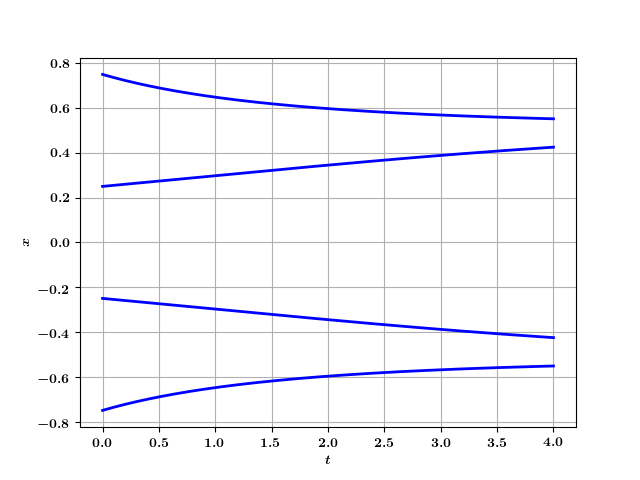

In [6]:
# -----------------------------------------------------------------
# --- Standart method (for reference) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)
mix.reload_module(kvn)

def solve_standart(x_center_ref):
    oo = RK45(
        lambda t,x: F_(x), 
        t[0], 
        [x_center_ref], t[-1], first_step=dt, max_step=dt
    )
    
    sol_ref = np.zeros(Nt, dtype=float)
    sol_ref[0] = x_center_ref
    Nt_act = 1
    
    oo.step()
    oo.t
    while mix.compare_two_strings(oo.status, "running"):
        oo.step()
        Nt_act += 1
        if Nt_act - 1 == Nt:
            print(oo.t)
        sol_ref[Nt_act-1] = float(oo.y[0])
    return sol_ref
# --------------------------------------------------------------------------

if flag_sim_:
    sol_refs = []
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i_center in range(len(x_centers_)):
        x_center = x_centers_[i_center]
    
        # --- Solve for the particular x_center ---
        sol_one = solve_standart(x_center)
        sol_refs.append(sol_one)
    
        # --- Plotting ---
        ax.plot(
            t, sol_one, 
            "b",
            # color=colors_[i_center], 
            linewidth = 2, linestyle='-', 
            # label = "xc = {:0.2f}".format(x_center)
        )
        del x_center
    plt.xlabel('$t$')
    plt.ylabel("$x$")
    # plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Simulations are blocked.")

In [ ]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [7]:
# --------------------------------------------------------------------------------
# --- Solve the system by using the KvN Hamiltonian ---
# --------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
from numba import njit
import time

# --- computation ---
if flag_sim_:
    st = time.time()
    
    psi_tx_matrix_CD   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx, psi_init_, H_CD)
    psi_tx_matrix_UW   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx, psi_init_, H_UW)
    psi_tx_matrix_DI   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx, psi_init_, H_DI)
    
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    # --- Compute the mean value ---
    mean_t_CD   = kvn.compute_mean_1D(x, Nt, psi_tx_matrix_CD)
    mean_t_UW   = kvn.compute_mean_1D(x, Nt, psi_tx_matrix_UW)
    mean_t_DI   = kvn.compute_mean_1D(x, Nt, psi_tx_matrix_DI)
else:
    print("Simulations are blocked.")

Execution time: 3.011324882507324 seconds


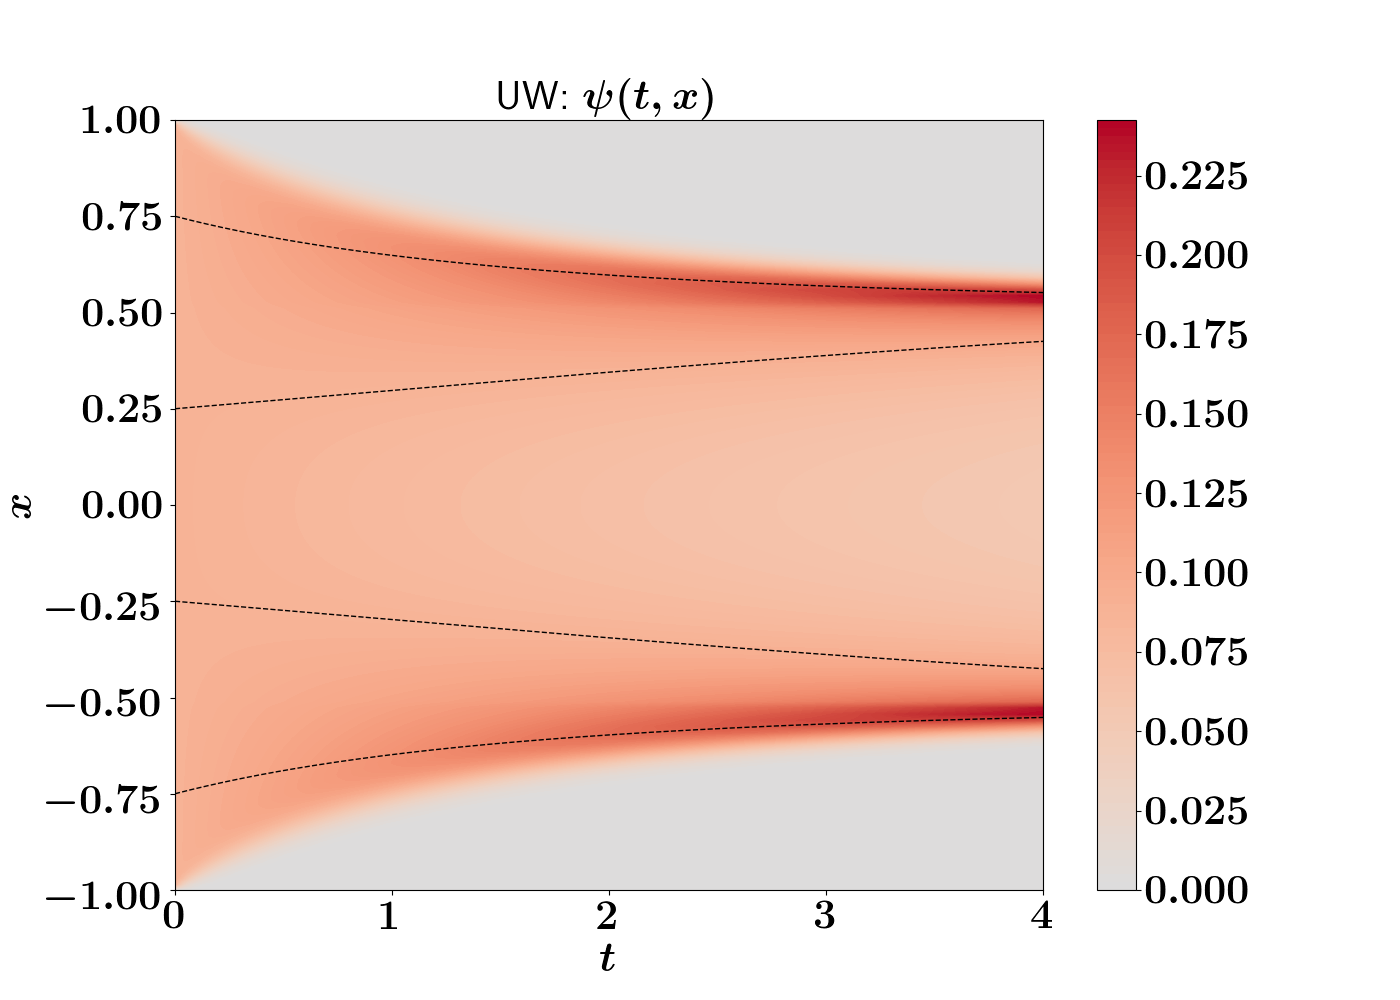

In [10]:
# ---------------------------------------------------------------------------------------------------
# --- Plot psi_tx_matrix(t,x) ---
# ---------------------------------------------------------------------------------------------------
from matplotlib import colors
# divnorm=colors.TwoSlopeNorm(vmin=-5., vcenter=0., vmax=10)
divnorm=colors.TwoSlopeNorm(vcenter=0.)

cmap_two_signs_= 'coolwarm'

if flag_sim_:
    flag_CDD = False
    # psi_tx_plot, mean_t_plot, str_title, str_fig = psi_tx_matrix_CD, mean_t_CD, "CD: ", "(a)"
    psi_tx_plot, mean_t_plot, str_title, str_fig = psi_tx_matrix_UW, mean_t_UW, "UW: ", "(b)"
    # psi_tx_plot, mean_t_plot, str_title, str_fig, flag_CDD = psi_tx_matrix_DI, mean_t_DI, "CDD: ", "(c)", True
    
    fontsize = 30
    linewidth = 4

    if not flag_CDD:
        str_Diff_title = ""
    else:
        str_Diff_title = ", $" + str_Diff + "$"

    if sel_case_ == 0:
        posx_text = 3.5

    if sel_case_ > 0:
        posx_text = 14.
        if sel_case_ == 1:
            str_fig, str_F, posx_text_F, posy_text_F = "(a)", "$F(x) = - x (x^2 - 0.25)$", 7, 0.84
            if flag_CDD:
                str_fig = "(d)"

        if sel_case_ == 2:
            str_fig, str_F, posx_text_F, posy_text_F = "(b)", "$F(x) = - x^2 (x - 0.8)^2 (x + 0.6)$", 1, -0.80
            if flag_CDD:
                str_fig = "(e)"
                posy_text_F = -0.86

        if sel_case_ == 3:
            str_fig, str_F, posx_text_F, posy_text_F = "(c)", "$F(x) = - (x - 0.50)$", 4, -0.80
            if flag_CDD:
                str_fig = "(f)"
                posy_text_F = -0.25

        if sel_case_ == 4:
            str_fig, str_F, posx_text_F, posy_text_F = "(d)", "$F(x) = - (x - 0.80)(x^4 - 0.09)$", 2, -0.80
            

    
    # --- Plotting ---
    XX, YY = np.meshgrid(t, x)
    # fig_tx = plt.figure(figsize=(12, 10))
    fig_tx = plt.figure(figsize=(14, 10))
    ax = fig_tx.add_subplot(111)
    cs = ax.contourf(
        XX, YY, np.transpose(psi_tx_plot.real), 
        levels=100, cmap=cmap_two_signs_, norm=divnorm
    )
    
    # cb = fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    cb = fig_tx.colorbar(cs, ax = ax)
    cb.ax.ticklabel_format(style="scientific")
    cb.ax.tick_params(labelsize=fontsize) 
    
    # ax.plot(t, mean_t_plot, color='black', linewidth = linewidth, linestyle=':', label="mean")
    
    # # -  standard simulations -
    coef_lw = 0.25
    ax.plot(t, sol_refs[0], color='black', linewidth = linewidth * coef_lw, linestyle='--', label="ref")
    for i_ref in range(1,len(sol_refs)):
        ax.plot(t, sol_refs[i_ref], color='black', linewidth = linewidth * coef_lw, linestyle='--')

    # t_point = 1.563
    # ax.axvline(
    #     t_point,
    #     ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
    #     color = "black", linewidth = linewidth, linestyle = ":"
    # )
    
    # ax.legend()
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_ylabel('$x$', fontsize = fontsize)
    ax.set_title(str_title + '$\psi(t,x)$' + str_Diff_title, fontsize = fontsize)
    ax.set_xlim(0, t_max)
    ax.set_ylim(-x_max, x_max)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    ax.text(posx_text,   -0.9, str_fig, fontsize=1.5*fontsize)
    if sel_case_ > 0 and sel_case_ < 10:
        ax.text(posx_text_F, posy_text_F, str_F, fontsize=fontsize)
    
    del fontsize, fig_tx
else:
    print("Simulations are blocked.")

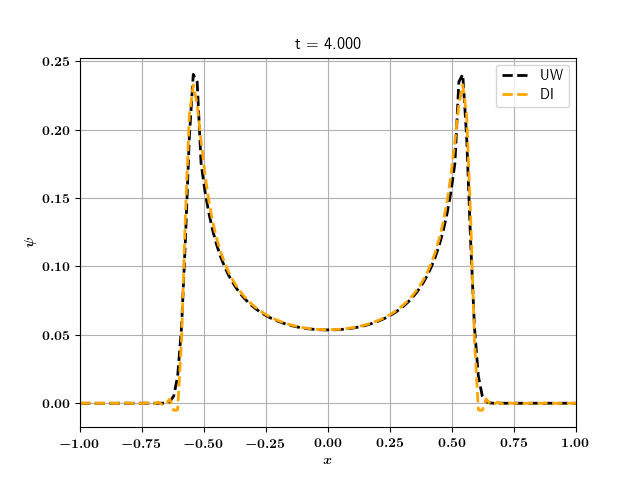


chosen time moment: 4.000


In [11]:
# ---------------------------------------------------------------------------------------------------
# --- Plot psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
flag_save = False
fname_CD = "CD_x_t1_sel{:d}.dat".format(sel_case_)
fname_UW = "UW_x_t1_sel{:d}.dat".format(sel_case_)
fname_DI = "DI_x_t1_sel{:d}_D{:0.1e}.dat".format(sel_case_, Di)

idt_moment = Nt - 1

flag_plot_CD = False

# ------------------------------------------------------------
if flag_sim_:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if flag_plot_CD:
        ax.plot(
            x, psi_tx_matrix_CD.real[idt_moment,:], 
            color="green", linewidth = 2.0, linestyle='-',
            label = "CD"
        )
#     ax.axvline(
#         sol_refs[0][idt_moment], 
#         ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
#         color = "r", linewidth = 1.6, linestyle = ":",
#         label = "ref"
#     )
#     for i_center in range(1, len(sol_refs)):
#         ax.axvline(
#             sol_refs[i_center][idt_moment], 
#             ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
#             color = "r", linewidth = 1.6, linestyle = ":"
#         )
    ax.plot(
        x, psi_tx_matrix_UW.real[idt_moment,:], 
        color="black", linewidth = 2.0, linestyle='--',
        label = "UW"
    )
    ax.plot(
        x, psi_tx_matrix_DI.real[idt_moment,:], 
        color="orange", linewidth = 2.0, linestyle='--',
        label = "DI"
    )
    plt.xlim([-x_max,x_max])
    plt.xlabel('$x$')
    plt.ylabel("$\psi$")
    plt.title("t = {:0.3f}".format(t[idt_moment]))
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Save the 1D data ---
    if flag_save:
#         mix.save_dat_plot_1d_file(
#             path_save_ + "/" + fname_CD, 
#             x, 
#             psi_tx_matrix_CD.real[idt_moment,:]
#         )
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + fname_UW, 
            x, 
            psi_tx_matrix_UW.real[idt_moment,:]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + fname_DI, 
            x, 
            psi_tx_matrix_DI.real[idt_moment,:]
        )
    # --- Print the reference points ---
#     print("\n--- reference points ---")
#     for i_center in range(len(sol_refs)):
#         print("{:0.3e}".format(sol_refs[i_center][idt_moment]))
    print()
    print("chosen time moment: {:0.3f}".format(t[idt_moment]))
else:
    print("Simulations are blocked.")

del idt_moment, flag_save, fname_CD, fname_UW, flag_plot_CD

In [ ]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [30]:
# ----------------------------------------------------------------------
# --- LCHS simulation (in python) ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
def LCHS_py(kmax, nk, ids_t_LCHS_py):
    print()
    print("--- Case: kmax = {:0.1f}, nk = {:d}".format(kmax, nk))

    # --- k-grid ---
    k_grid     = np.linspace(- kmax, kmax, 1 << nk)

    # --- computation ---
    psi_LCHS_py = np.zeros((len(ids_t_LCHS_py), Nx), dtype = complex)
    for counter_t in range(len(ids_t_LCHS_py)):
        id_t_LCHS_py = ids_t_LCHS_py[counter_t]
        print("LCHS at t = {:0.3e}".format(t[id_t_LCHS_py]))
        psi_LCHS_py[counter_t, :] = kvn.LCHS_computation(
            k_grid, dt,
            1.j*H_UW, psi_init_, id_t_LCHS_py, 
            flag_trotterization = True, 
            flag_print = False
        )
    print("Done.")
    
    # save results:
    dd = {
        "psi": psi_LCHS_py,
        "nk": nk,
        "kmax": kmax
    }
    return dd

def gkL(kmax, nk):
    return format("{:0.1f} {:d}".format(kmax, nk))
# ------------------------------------------------------------------------

# time points where the LCHS statevector is calculated: 
ids_t_LCHS_py = [
    Nt//3, 
    Nt//2, 
    Nt//10*9
]
dds_LCHS_py = {}

# kmax, nk = 10., 5
# dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 10., 7
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

# kmax, nk = 10., 8
# dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

# kmax, nk = 20., 8
# dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

# kmax, nk = 40., 9
# dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)


--- Case: kmax = 10.0, nk = 7
LCHS at t = 1.333e+00
LCHS at t = 2.000e+00
LCHS at t = 3.600e+00
Done.



chosen time moment: 1.333


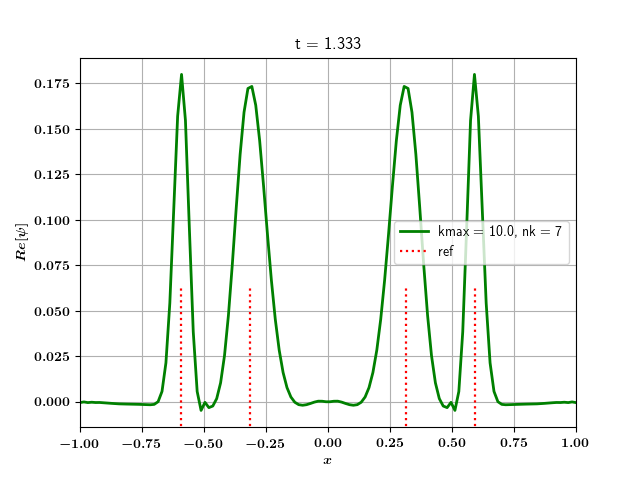


chosen time moment: 2.000


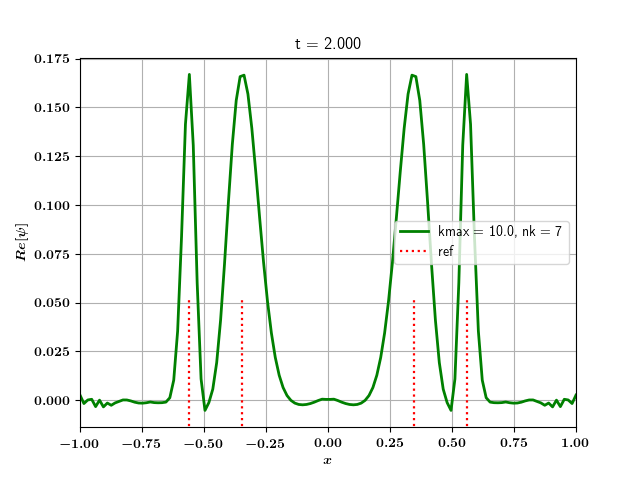


chosen time moment: 3.600


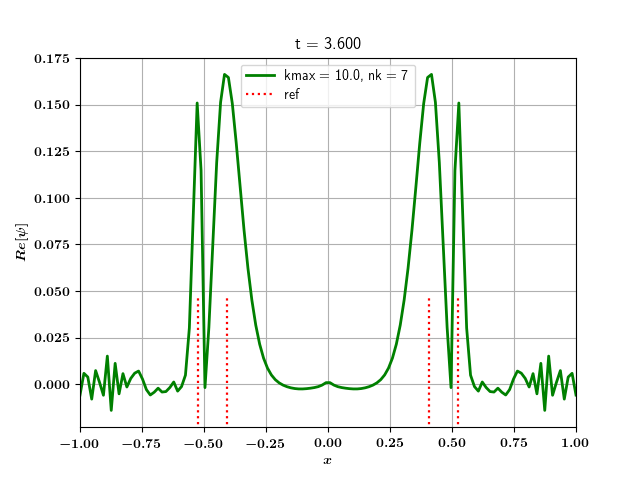


--- t0 = 1.333 ---
-3.137e-01
3.137e-01
5.914e-01
-5.914e-01
--- t1 = 2.000 ---
-3.448e-01
3.448e-01
5.605e-01
-5.605e-01
--- t2 = 3.600 ---
-4.088e-01
4.088e-01
5.247e-01
-5.247e-01


In [31]:
# ----------------------------------------------------------------------
# --- Plot results from the python LCHS simulation ---
# ----------------------------------------------------------------------
def plot_LCHS_py(dds):
    for counter_t in range(len(ids_t_LCHS_py)):
        id_t_LCHS_py = ids_t_LCHS_py[counter_t]

        print()
        print("chosen time moment: {:0.3f}".format(t[id_t_LCHS_py]))
        
        colors_loc = ["green", "blue", "black", "magenta"]
        line_styles = ["-", "--", "--"]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for ii in range(len(dds)):
            ax.plot(
                x, 
                dds[ii]["psi"].real[counter_t, :], 
                color=colors_loc[ii], 
                linewidth = 2.0, 
                linestyle=line_styles[ii],
                label = "kmax = {:0.1f}, nk = {:d}".format(
                    dds[ii]["kmax"], dds[ii]["nk"]
                )
            )
        
        ax.axvline(
            sol_refs[0][id_t_LCHS_py], 
            ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
            color = "r", linewidth = 1.6, linestyle = ":",
            label = "ref"
        )
        for i_center in range(1, len(sol_refs)):
            ax.axvline(
                sol_refs[i_center][id_t_LCHS_py], 
                ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
                color = "r", linewidth = 1.6, linestyle = ":"
            )
        plt.xlim([-x_max,x_max])
        plt.xlabel('$x$')
        plt.ylabel("$Re[\psi]$")
        plt.title("t = {:0.3f}".format(t[id_t_LCHS_py]))
        plt.grid(True)
        plt.legend()
        plt.show()

    
def save_LCHS_py(kmax, nk, fname_LCHS_py, counter_t):
    fname = "{:s}{:d}_k{:d}_n{:d}.dat".format(
        fname_LCHS_py, counter_t, int(kmax), nk
    )
    mix.save_dat_plot_1d_file(
        path_save_ + "/" + fname, 
        x, 
        dds_LCHS_py[gkL(kmax, nk)]["psi"].real[counter_t,:]
    )
    
    
# -----------------------------------------------------------------------------------------
    
    
flag_save = False
flag_plot = True

# kmax_plot, nk_plot = [10, 10, 10], [5, 7, 8]
# kmax_plot, nk_plot = [10, 20, 40], [7, 8, 9]
kmax_plot, nk_plot = [10], [7]


# --- Plotting ---
if flag_plot:
    # dds_plot = [
    #     dds_LCHS_py[gkL(kmax_plot[0], nk_plot[0])],
    #     dds_LCHS_py[gkL(kmax_plot[1], nk_plot[1])],
    #     dds_LCHS_py[gkL(kmax_plot[2], nk_plot[2])]
    # ]
    dds_plot = [
        dds_LCHS_py[gkL(kmax_plot[0], nk_plot[0])],
    ]
    plot_LCHS_py(dds_plot)
    
# --- Print reference peaks ---
print()
for counter_t in range(len(ids_t_LCHS_py)):
    id_t_LCHS_py = ids_t_LCHS_py[counter_t]
    print("--- t{:d} = {:0.3f} ---".format(
        counter_t, t[id_t_LCHS_py]
    ))
    for i_center in range(len(sol_refs)):
        print("{:0.3e}".format(sol_refs[i_center][id_t_LCHS_py]))

# --- Save the 1D data ---
if flag_save:
    print()
    fname_LCHS_py = "LCHS_py_x_t"
    for counter_t in range(len(ids_t_LCHS_py)):
        save_LCHS_py(kmax_plot[0], nk_plot[0], fname_LCHS_py, counter_t)
        save_LCHS_py(kmax_plot[1], nk_plot[1], fname_LCHS_py, counter_t)
        save_LCHS_py(kmax_plot[2], nk_plot[2], fname_LCHS_py, counter_t)

del flag_save